# Deep HHD: Ocean Data
Andrew Sosanya, Sam Greydanus | 2021

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter
import scipy.integrate
from functools import partial
import os, copy, time, pickle, autograd

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

import torch
import torch.nn as nn
import torch.nn.functional as F

import deephhd
from deephhd.models import MLP, HHD, HNN
from deephhd.train import train, get_args
from deephhd.utils import from_pickle
from deephhd.numeric import coords2fields, get_interp_model, approx_helmholtz_decomp
from deephhd.experiment_ocean.data import get_ocean_data

## Load ocean data, proces it, and make a dataset

In [3]:
GRIDSIZE = 30
def get_ocean_data(args):
    atlantic = from_pickle('./experiment_ocean/oscar_vel2020_preprocessed.pkl')
    atlantic = np.nan_to_num(atlantic) #change all NaNs to 0
    atlantic[:,-1] = -1 * atlantic[:,-1]  # flip y axes; we will be plotting with flipped y coordinates
#     atlantic = atlantic[:,:,100:150,100:150]
    # atlantic = atlantic[:,:,100:115,100:115]
    atlantic = atlantic[:,:,90:120,90:120]
    # atlantic[...,:1,:1] = atlantic[...,-1:,-1:] = 0 # set boundary conditions (optional)
    x, y = np.meshgrid(range(atlantic.shape[2]), range(atlantic.shape[3]))
    xy_max = 1. * max(x.max(), y.max())

    # Reshaping our data to fit convention of x = input, y = target
    x = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1) 
    y = np.concatenate([atlantic[0,0,:,:].reshape(-1,1),
                      atlantic[0,1,:,:].reshape(-1,1)], axis=1)

    # Normalize inputs and outputs (putting them all roughly in [-1,1])
    x = 3 * x/xy_max ; y = 3 * y/xy_max  # divide by the maximum coordinate value
    x -= x.mean() ; y -= y.mean() # center the coodinates about zero
    y = (y-y.mean()) / (y.std())  # simple normalization


    # Shuffle the dataset so there aren't any order effects
    shuffle_ixs = np.random.permutation(x.shape[0])
    x, y = x[shuffle_ixs], y[shuffle_ixs]

    # Split the dataset into it's training and testing components.
    #   axes of tensors are [dataset_size, coordinates] (where coordinates = features)
    split_ix = int(x.shape[0]*args.train_split) # train / test split
    data = {'x': x[:split_ix], 'x_test': x[split_ix:], 
          'dx': y[:split_ix], 'dx_test': y[split_ix:]}
    return data

# args = get_args()
# data = get_ocean_data(args=args)
# data['x'].min(), data['x'].max(), data['dx'].min(), data['dx'].max()

## Make the dataset

(900, 2)


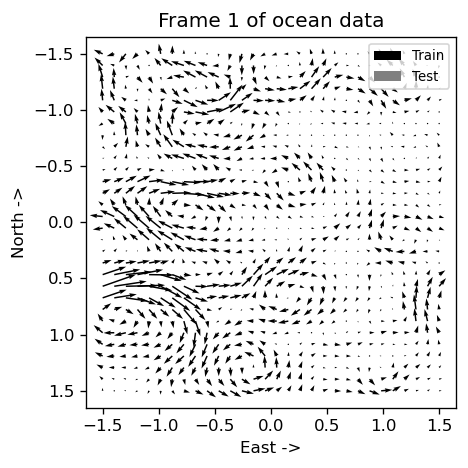

In [4]:
qkwargs = {'width': 4e-3, 'scale': 60} # quiver kwargs

args = get_args()
args.train_split = 95
data = get_ocean_data(args)
print(data['x'].shape)

fig = plt.figure(figsize=[4,4], dpi=120) # Visualize HHD output

plt.subplot(1,1,1)  # plotting the original composite vector field
plt.title("Frame 1 of ocean data")
plt.gca().invert_yaxis()
plt.quiver(data['x'][:,0],data['x'][:,1], 
           data['dx'][:,0], -data['dx'][:,1], 
           color='k', label='Train', **qkwargs) #composite vector field
plt.quiver(data['x_test'][:,0],data['x_test'][:,1], 
           data['dx_test'][:,0], -data['dx_test'][:,1], 
           color='gray', label='Test', **qkwargs)
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('East ->') ; plt.ylabel('North ->')
plt.tight_layout() ; plt.show()

## Do a hand-constructed Helmholtz decomposition
We'll use the Gauss-Seidel method. It's an approximate method, but as we'll see, the lion's share of error comes from interpolating the field into a meshgrid. We use nearest neighbors for interpolation because the 'cubic' and 'linear' modes give worse results.

(30, 30, 2)


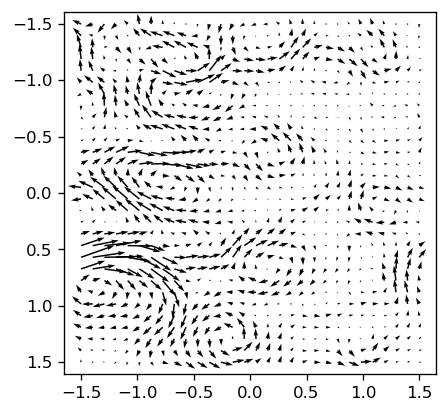

In [5]:
from scipy import interpolate
import numpy as np
from functools import partial

def get_interp_model(x, dx, method='cubic'):
    return partial(interpolate.griddata, x, dx, method=method)
    
def coords2fields(x, dx, hw=None, replace_nans=True, method='nearest', verbose=True):
    '''The x and dx coords are shuffled along the batch dimension. We need to
    run an interpolation routine in order to obtain a tensor representation of the field.'''
    if hw is None:
        h = w = GRIDSIZE # assume h=w and x=h*w
        if verbose: print('Using gridsize={}'.format(GRIDSIZE))
    else:
        (h, w) = hw
    xx = np.linspace(x[:,0].min(), x[:,1].max(), w)
    yy = np.linspace(x[:,0].min(), x[:,1].max(), h)
    x_field = np.stack(np.meshgrid(xx, yy), axis=-1)
    print(x_field.shape)
    
    interp_model = get_interp_model(x, dx, method=method)
    dx_field = interp_model(x_field)
    if replace_nans:
        dx_field[np.where(np.isnan(dx_field))] = np.nanmean(dx_field)
    return x_field, dx_field


x, dx = coords2fields(data['x'], data['dx'], hw=(GRIDSIZE,GRIDSIZE))
plt.figure(figsize=[4,4], dpi=120)
plt.gca().invert_yaxis()
plt.quiver(x[...,0], x[...,1], dx[...,0], -dx[...,1], **qkwargs)
plt.axis('equal') ; plt.show()

interp_model = get_interp_model(data['x'], data['dx'])

(30, 30)


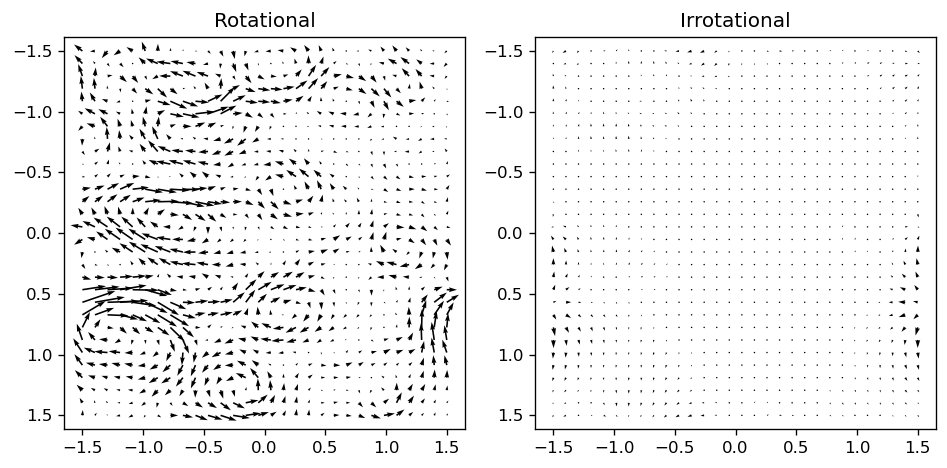

In [6]:
x_field, dx_field, dx_rot, dx_irr = approx_helmholtz_decomp(data['x'], data['dx'], hw=(GRIDSIZE,GRIDSIZE))

fig = plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1) ; plt.title('Rotational')
plt.gca().invert_yaxis()
plt.quiver(x_field[...,0], x_field[...,1], dx_rot[...,0], -dx_rot[...,1], color='k', **qkwargs)
plt.axis('equal')

plt.subplot(1,2,2) ; plt.title('Irrotational')
plt.gca().invert_yaxis()
plt.quiver(x_field[...,0], x_field[...,1], dx_irr[...,0], -dx_irr[...,1], color='k', **qkwargs)
plt.axis('equal')

plt.tight_layout() ; plt.show()

## Train models

In [7]:
args = get_args()
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
data = get_ocean_data(args=args)
mlp_model = MLP(args.input_dim, args.output_dim, args.hidden_dim)
mlp_results = train(mlp_model, args, data)  # training the model

step 0, dt 0.003, train_loss 1.13e+00, test_loss 1.25e+00
step 200, dt 0.152, train_loss 9.18e-01, test_loss 9.79e-01
step 400, dt 0.145, train_loss 8.73e-01, test_loss 9.13e-01
step 600, dt 0.130, train_loss 8.77e-01, test_loss 8.80e-01
step 800, dt 0.139, train_loss 7.37e-01, test_loss 7.65e-01
step 1000, dt 0.139, train_loss 5.58e-01, test_loss 7.03e-01
step 1200, dt 0.142, train_loss 4.90e-01, test_loss 6.22e-01
step 1400, dt 0.150, train_loss 5.04e-01, test_loss 5.54e-01
step 1600, dt 0.144, train_loss 5.62e-01, test_loss 4.96e-01
step 1800, dt 0.160, train_loss 5.12e-01, test_loss 4.52e-01
step 2000, dt 0.160, train_loss 4.78e-01, test_loss 4.26e-01
step 2200, dt 0.155, train_loss 4.47e-01, test_loss 4.18e-01
step 2400, dt 0.149, train_loss 3.28e-01, test_loss 4.04e-01
step 2600, dt 0.174, train_loss 3.19e-01, test_loss 3.84e-01
step 2800, dt 0.210, train_loss 2.46e-01, test_loss 3.74e-01
step 3000, dt 0.250, train_loss 2.74e-01, test_loss 3.51e-01
step 3200, dt 0.269, train_loss

In [8]:
args = get_args()
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
data = get_ocean_data(args=args)
hnn_model = HNN(args.input_dim, args.hidden_dim)
hnn_results = train(hnn_model, args, data)  # training the model

step 0, dt 0.003, train_loss 1.13e+00, test_loss 1.09e+00
step 200, dt 0.214, train_loss 8.34e-01, test_loss 8.56e-01
step 400, dt 0.205, train_loss 5.90e-01, test_loss 5.24e-01
step 600, dt 0.199, train_loss 4.25e-01, test_loss 3.91e-01
step 800, dt 0.201, train_loss 3.12e-01, test_loss 3.11e-01
step 1000, dt 0.196, train_loss 2.46e-01, test_loss 2.87e-01
step 1200, dt 0.202, train_loss 2.10e-01, test_loss 2.51e-01
step 1400, dt 0.201, train_loss 1.74e-01, test_loss 2.16e-01
step 1600, dt 0.205, train_loss 1.61e-01, test_loss 1.92e-01
step 1800, dt 0.215, train_loss 2.46e-01, test_loss 1.62e-01
step 2000, dt 0.214, train_loss 1.59e-01, test_loss 1.48e-01
step 2200, dt 0.211, train_loss 1.45e-01, test_loss 1.37e-01
step 2400, dt 0.210, train_loss 1.37e-01, test_loss 1.34e-01
step 2600, dt 0.208, train_loss 1.21e-01, test_loss 1.38e-01
step 2800, dt 0.222, train_loss 1.11e-01, test_loss 1.31e-01
step 3000, dt 0.219, train_loss 1.35e-01, test_loss 1.30e-01
step 3200, dt 0.229, train_loss

In [9]:
args = get_args()
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
data = get_ocean_data(args=args)
hhd_model = HHD(args.input_dim, args.hidden_dim)
hhd_results = train(hhd_model, args, data)  # training the model

step 0, dt 0.004, train_loss 1.01e+00, test_loss 1.73e+00
step 200, dt 0.346, train_loss 8.35e-01, test_loss 8.91e-01
step 400, dt 0.338, train_loss 6.29e-01, test_loss 5.55e-01
step 600, dt 0.346, train_loss 4.29e-01, test_loss 4.07e-01
step 800, dt 0.337, train_loss 3.34e-01, test_loss 3.26e-01
step 1000, dt 0.337, train_loss 2.61e-01, test_loss 3.29e-01
step 1200, dt 0.336, train_loss 2.47e-01, test_loss 3.14e-01
step 1400, dt 0.335, train_loss 2.18e-01, test_loss 2.46e-01
step 1600, dt 0.390, train_loss 2.04e-01, test_loss 2.02e-01
step 1800, dt 0.333, train_loss 2.55e-01, test_loss 1.76e-01
step 2000, dt 0.350, train_loss 1.83e-01, test_loss 1.66e-01
step 2200, dt 0.355, train_loss 1.57e-01, test_loss 1.66e-01
step 2400, dt 0.359, train_loss 1.38e-01, test_loss 1.60e-01
step 2600, dt 0.372, train_loss 1.18e-01, test_loss 1.63e-01
step 2800, dt 0.372, train_loss 1.22e-01, test_loss 1.54e-01
step 3000, dt 0.378, train_loss 1.48e-01, test_loss 1.49e-01
step 3200, dt 0.381, train_loss

In [10]:
def print_stats(results):
    stats_last = lambda v: (np.mean(v[-5:]), np.std(v[-5:]))
    
    metrics = ['train_loss', 'test_loss']
    print("\t" + " & ".join(metrics), end='\n\t')
    for metric in metrics:
        print("{:.2e} \pm {:.2e}".format(*stats_last(results[metric])), end=' & ')
    
    print("LaTeX format", end='\n\t')
    for metric in metrics:
        print("{:.2e}".format(np.mean((results[metric])[-3:])), end=' & ')

print('HHD') ; print_stats(hhd_results)
print('\nHNN') ; print_stats(hnn_results)
print('\nMLP') ; print_stats(mlp_results)

HHD
	train_loss & test_loss
	1.22e-01 \pm 1.83e-02 & 1.13e-01 \pm 3.85e-03 & LaTeX format
	1.33e-01 & 1.11e-01 & 
HNN
	train_loss & test_loss
	1.09e-01 \pm 1.92e-02 & 9.72e-02 \pm 2.01e-03 & LaTeX format
	1.21e-01 & 9.72e-02 & 
MLP
	train_loss & test_loss
	1.93e-01 \pm 3.21e-02 & 1.74e-01 \pm 1.28e-02 & LaTeX format
	2.06e-01 & 1.76e-01 & 

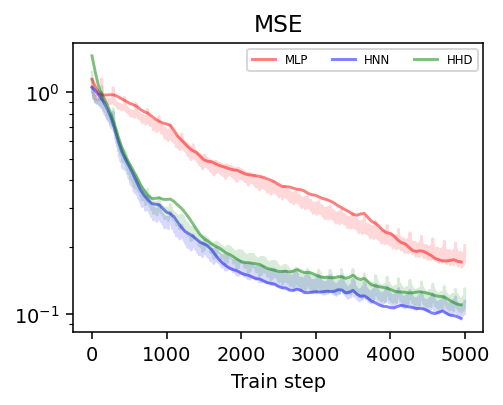

In [11]:
smooth = gaussian_filter # name this function so it takes up less space below
t_eval = list(range(0,args.total_steps, args.test_every))
k, l = 2, 1

fig = plt.figure(figsize=[3.7,3], dpi=140)
plt.plot(smooth(mlp_results['train_loss'], k), color='r', alpha=0.15)
plt.plot(t_eval, smooth(mlp_results['test_loss'], l), color='r', alpha=0.5, label='MLP')

plt.plot(smooth(hnn_results['train_loss'], k), color='b', alpha=0.15)
plt.plot(t_eval, smooth(hnn_results['test_loss'], l), color='b', alpha=0.5, label='HNN')

plt.plot(smooth(hhd_results['train_loss'], k), color='g', alpha=0.15)
plt.plot(t_eval, smooth(hhd_results['test_loss'], l), color='g', alpha=0.5, label='HHD')

# plt.plot([0,5000], [baseline_err]*2, 'k--', label='Analytic HHD')

plt.title('MSE') ; plt.xlabel('Train step') ; plt.yscale('log')
plt.legend(ncol=4, fontsize=6)
plt.tight_layout() ; plt.show()
fig.savefig('./static/ocean_training.pdf')

## Visualize model predictions

In [12]:
print(data['x'].shape)
[x, x_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32) for v in ['x', 'x_test']]
print(x.shape)
y_hat_irr, y_hat_rot = hhd_model(x, as_separate=True)
y_hat_irr = y_hat_irr.detach().numpy()
y_hat_rot = y_hat_rot.detach().numpy()
y_hat = y_hat_rot + y_hat_irr

y_hat_irr_test, y_hat_rot_test = hhd_model(x_test, as_separate=True)
y_hat_irr_test = y_hat_irr_test.detach().numpy()
y_hat_rot_test = y_hat_rot_test.detach().numpy()
y_hat_test = y_hat_rot_test + y_hat_irr_test

(765, 2)
torch.Size([765, 2])


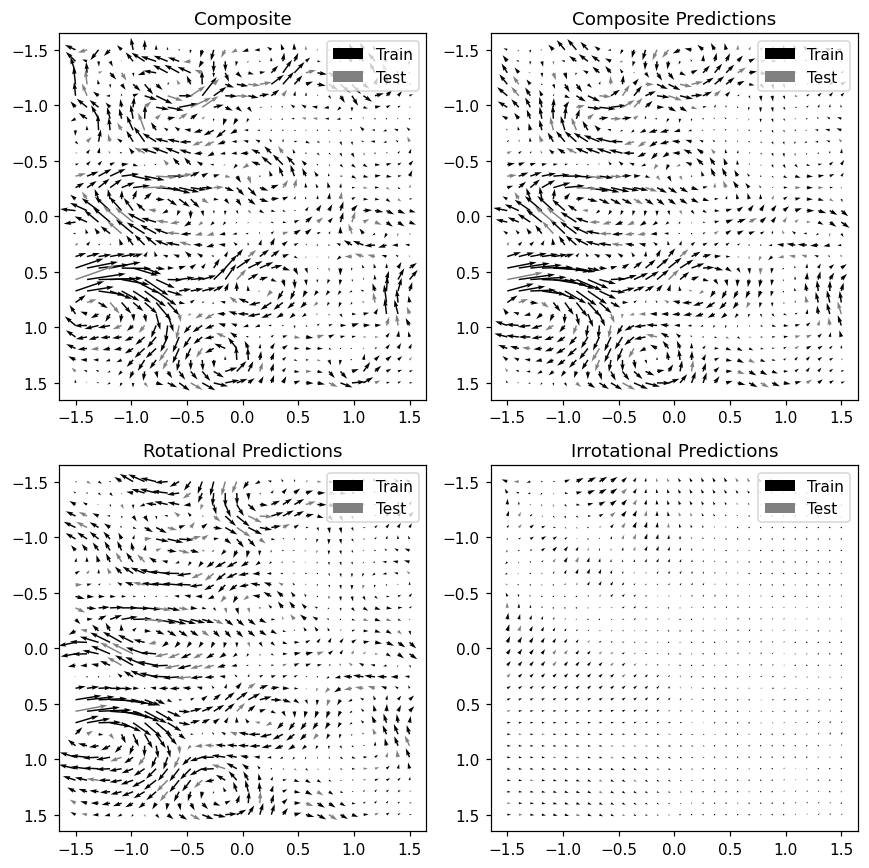

In [13]:
qkwargs = {'width': 4e-3, 'scale': 50} # quiver kwargs
# qkwargs = {'width': None, 'scale': None} # quiver kwargs

fig = plt.figure(figsize=[8,8], dpi=110) # Visualize HHD output

plt.subplot(2,2,1)  # plotting the original composite vector field
plt.title("Composite")
plt.gca().invert_yaxis()
plt.quiver(data['x'][:,0],data['x'][:,1], 
           data['dx'][:,0], -data['dx'][:,1], 
           color='black', label='Train', **qkwargs) #composite vector field
plt.quiver(data['x_test'][:,0],data['x_test'][:,1], 
           data['dx_test'][:,0], -data['dx_test'][:,1], 
           color='gray', label='Test', **qkwargs)
plt.legend()


plt.subplot(2,2,2)  # Plotting the predicted composite vector field
plt.title("Composite Predictions")
plt.gca().invert_yaxis()
plt.quiver(data['x'][:,0],data['x'][:,1], 
           y_hat[:,0], -y_hat[:,1], 
           color='black', label='Train', **qkwargs) 
plt.quiver(data['x_test'][:,0],data['x_test'][:,1], 
           y_hat_test[:,0], -y_hat_test[:,1], 
           color='gray', label='Test', **qkwargs)
plt.legend()



plt.subplot(2,2,3)  # Plotting the predicted rotational vector field
plt.title("Rotational Predictions")
plt.gca().invert_yaxis()

plt.quiver(data['x'][:,0],data['x'][:,1], 
           y_hat_rot[:,0], -y_hat_rot[:,1], 
           color='black', label='Train', **qkwargs) #rotational vector field
plt.quiver(data['x_test'][:,0],data['x_test'][:,1], 
           y_hat_rot_test[:,0], -y_hat_rot_test[:,1], 
           color='gray', label='Test', **qkwargs)
plt.legend()

plt.subplot(2,2,4)  # Plotting the predicted irrotational vector field
plt.title("Irrotational Predictions")
plt.gca().invert_yaxis()
plt.quiver(data['x'][:,0],data['x'][:,1], 
           y_hat_irr[:,0], -y_hat_irr[:,1], 
           color='black', label='Train', **qkwargs) #irrotational vector field
plt.quiver(data['x_test'][:,0],data['x_test'][:,1], 
           y_hat_irr_test[:,0], -y_hat_irr_test[:,1], 
           color='gray', label='Test', **qkwargs)
plt.legend()

plt.tight_layout() ;  plt.show()

## Let's visualize the scalar fields

In [14]:
def get_interp_model(x, dx, method='cubic'):
    return partial(interpolate.griddata, x, dx, method=method)
    
def coords2fields(x, dx, hw=None, replace_nans=True, method='nearest', verbose=True):
    '''The x and dx coords are shuffled along the batch dimension. We need to
    run an interpolation routine in order to obtain a tensor representation of the field.'''
    if hw is None:
        h = w = GRIDSIZE # assume h=w and x=h*w
        if verbose: print('Using gridsize={}'.format(GRIDSIZE))
    else:
        (h, w) = hw
    xx = np.linspace(x[:,0].min(), x[:,1].max(), w)
    yy = np.linspace(x[:,0].min(), x[:,1].max(), h)
    x_field = np.stack(np.meshgrid(xx, yy), axis=-1)
    print(x_field.shape)
    
    interp_model = get_interp_model(x, dx, method=method)
    dx_field = interp_model(x_field)
    if replace_nans:
        dx_field[np.where(np.isnan(dx_field))] = np.nanmean(dx_field)
    return x_field, dx_field

In [15]:
def interpolate_scalar(x, S):
    w, h = (GRIDSIZE, GRIDSIZE)
    xx = np.linspace(x[:,0].min(), x[:,1].max(), 3*w)
    yy = np.linspace(x[:,0].min(), x[:,1].max(), 3*h)
    x_field = np.stack(np.meshgrid(xx, yy), axis=-1)

    interp_model = get_interp_model(x, S, method='nearest')
    return interp_model(x_field)

x = data['x'] # [B x 2]
x_ = torch.tensor(x, requires_grad=True,  dtype=torch.float32)
D = hhd_model.mlp_d(x_).cpu().detach().numpy() # [B x 1]
H = hhd_model.mlp_h(x_).cpu().detach().numpy() # [B x 1]

D_field = interpolate_scalar(x, D)[...,0]
H_field = interpolate_scalar(x, H)[...,0]

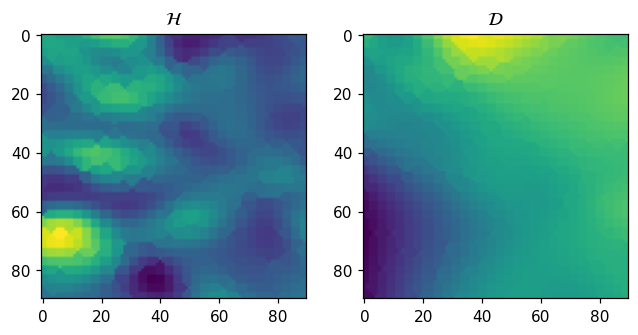

In [19]:
fig = plt.figure(figsize=[6,3], dpi=110) # Visualize HHD output

plt.subplot(1,2,1)
plt.title('$\mathcal{H}$')
plt.gca().invert_yaxis()
plt.imshow(H_field)

plt.subplot(1,2,2)
plt.title('$\mathcal{D}$')
plt.gca().invert_yaxis()
plt.imshow(D_field)

plt.tight_layout() ;  plt.show()

## Let's make a movie of this effect

In [22]:
# rho0 = RHO
# rhos = np.linspace(0,1.2,40)

# ARROW_SCALE = 25
# ARROW_WIDTH = 5e-3
# qkwargs = {'width': ARROW_WIDTH, 'scale': ARROW_SCALE} # quiver kwargs

# rows, cols = 1, 3
# xmin, xmax, ymin, ymax = -1.2,1.2,-1.2,1.2
# fig = plt.figure(figsize=[7.5,3], dpi=200) #dpi=120 # Visualize HHD output
# # fig, (ax1, ax2) = plt.subplots(1, 3, figsize=[7.5,3], dpi=150)
# path = './static/dampedspring_counterfactual.mp4'
# camera = Camera(fig)

# axes = [plt.subplot(rows,cols,1), plt.subplot(rows,cols,2), plt.subplot(rows,cols,3)]

# for (i, rho) in enumerate(rhos):
#     np.random.seed(args.seed)
#     new_data = get_dampedspring_data(args, rho=rho)

#     t_span = [0,4]
#     y0 = np.asarray([0.9, 0])
#     kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}

#     analytic_model_new = partial(analytic_model, rho=rho)
#     def hhd_model_new(x):
#         hhd_irr, hhd_rot = hhd_model(x, as_separate=True)
#         return hhd_rot + rho/rho0*hhd_irr

#     ana_ivp = integrate_model(analytic_model_new, t_span, y0, use_torch=False, **kwargs)
#     hhd_ivp = integrate_model(hhd_model_new, t_span, y0, **kwargs)
    
#     plot_data = [
#         {'title': 'Full system'.format(rho), 'data': new_data, 'train': new_data['dx'],
#          'test': new_data['dx_test'], 'ana': ana_ivp['y'], 'hhd': hhd_ivp['y'], 'visible': True},
#         {'title': 'Conservative field', 'data': new_data, 'train': new_data['dx_rot'],
#          'test': new_data['dx_rot_test'], 'visible': True},
#         {'title': 'Dissipative field', 'data': new_data, 'train': new_data['dx_irr'],
#          'test': new_data['dx_irr_test'], 'visible': True}
#     ]
    
#     for r in range(rows):
#         for c in range(cols):
#             ix = c + r*cols

#             if plot_data[ix]['visible']:
#                 ax = axes[ix]
#                 ax.set_xlabel('q') ; ax.set_ylabel('p')
#                 ax.set_aspect(1 / ax.get_data_ratio())
#                 ax.set_xlim(xmin, xmax) ; ax.set_ylim(ymin, ymax)

#             if 'train' in plot_data[ix].keys():
#                 ax.quiver(*plot_data[ix]['data']['x'].T, *plot_data[ix]['train'].T, label=None, **qkwargs)
#                 ax.quiver(*plot_data[ix]['data']['x_test'].T, *plot_data[ix]['test'].T, label=None,
#                            color=gray, **qkwargs)

#             if 'ana' in plot_data[ix].keys():
#                 ana_traj = plot_data[ix]['ana'].T
#                 ax.plot(*ana_traj.T, color='k', linewidth=LINE_WIDTH, label='True' if i==0 else None)

#                 hhd_traj = plot_data[ix]['hhd'].T
#                 ax.plot(*hhd_traj.T, color='g', linewidth=LINE_WIDTH, label='HHD' if i==0 else None)

#             if 'title' in plot_data[ix].keys():
#                 ax.set_title(plot_data[ix]['title'])

#             if ix==0:
#                 ax.legend(loc=loc, fontsize=6, ncol=2, framealpha=1)
#     plt.tight_layout()
#     camera.snap()
# #     plt.close(fig)
    
# plt.close()
# anim = camera.animate(blit=True, interval=220)
# anim.save(path)

In [23]:
# # Plot the video below this cell
# print('\n', path)
# mp4 = open(path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# HTML("""
# <video width=800 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)


 ./static/dampedspring_counterfactual.mp4
